# 1. Import and setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

from scipy.stats import pearsonr, ttest_ind
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setting up styling
sns.set(style="darkgrid")
sns.set_palette("flare")

print(sns.color_palette("flare").as_hex())
palette = sns.color_palette("flare").as_hex()
sns.color_palette("flare")

['#e98d6b', '#e3685c', '#d14a61', '#b13c6c', '#8f3371', '#6c2b6d']


[(0.9155979, 0.55210684, 0.42070204),
 (0.888292, 0.40830288, 0.36223756),
 (0.81942908, 0.28911553, 0.38102921),
 (0.69226314, 0.23413578, 0.42480327),
 (0.56041794, 0.19845221, 0.44207535),
 (0.42355299, 0.16934709, 0.42581586)]

In [3]:
RANDOM_STATE=42

# 2. Read dataset

In [4]:
df = pd.read_csv('../dataset/digital_phenotype_cohort.csv', index_col=0)
df.head()

hadm_id  alcoholism gender  anchor_age            deathtime  \
0  26100575           0      F          71                  NaN   
1  22698313           0      F          89  2164-09-06T02:23:00   
2  29562026           0      F          84                  NaN   
3  21607777           0      F          37                  NaN   
4  25233292           0      M          47                  NaN   

   hematocrit_serum  c_creative_protein  blood_urea_nitrogen  \
0              31.3                 NaN                 28.0   
1              19.9                 NaN                 40.0   
2              22.5                 NaN                 26.0   
3              29.5                 NaN                 31.0   
4              29.9                 NaN                 97.0   

   serum_creatinine  Non_Invasive_Blood_Pressure_systolic  ...  platelet_PLT  \
0               1.2                                 158.0  ...         107.0   
1               1.0                                 107.0  ...         183.0   
2               0.7                                 118.0  ...         160.0   
3               2.0                                  76.0  ...         239.0   
4               6.8                                 137.0  ...         137.0   

   Prothrombin_time  aminotransferase_ALT  Total_Bilirubin  \
0              13.2                   NaN              NaN   
1              16.4                  28.0              0.4   
2              17.4                  27.0              2.8   
3              15.8                 168.0              1.1   
4              12.7                 473.0              0.4   

   lactate_dehydrogenase_LDH  Anion_gap  Heart_rate_Alarm_High  \
0                        NaN       11.0                  125.0   
1                      265.0       23.0                  130.0   
2                      317.0       14.0                  120.0   
3                      347.0       13.0                  150.0   
4                      666.0       24.0                  130.0   

   Heart_rate_Alarm_low  earliest_weight_kg  earliest_height_cm  
0                  60.0                59.7                 NaN  
1                  40.0                56.0                 NaN  
2                  50.0                78.1               152.4  
3                  40.0                52.2               155.0  
4                  50.0               103.4               183.0  

[5 rows x 26 columns]

In [5]:
# Label mortality
df['mortality'] = df['deathtime'].apply(lambda x: 'Survive' if x is np.nan else 'Dead')
df['mortality'].value_counts()

mortality
Survive    339
Dead        63
Name: count, dtype: int64

In [6]:
df.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'deathtime',
       'hematocrit_serum', 'c_creative_protein', 'blood_urea_nitrogen',
       'serum_creatinine', 'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'Serum_Amylase', 'lipase',
       'white_bloodcells', 'lactate_dehydrogenase', 'Glucose_serum',
       'platelet_PLT', 'Prothrombin_time', 'aminotransferase_ALT',
       'Total_Bilirubin', 'lactate_dehydrogenase_LDH', 'Anion_gap',
       'Heart_rate_Alarm_High', 'Heart_rate_Alarm_low', 'earliest_weight_kg',
       'earliest_height_cm', 'mortality'],
      dtype='object')

# 3. Exploratory Data

## 3.1. General Statistics

In [7]:
df.shape

(402, 27)

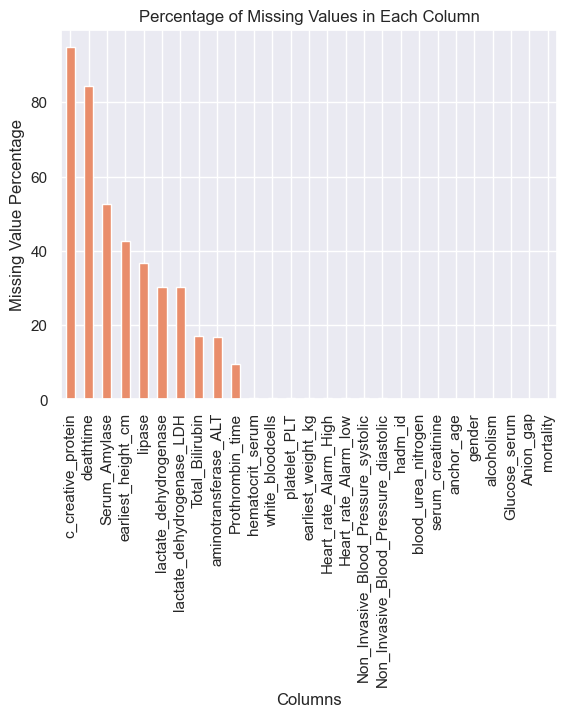

In [59]:
# Datatype and missing value information
missing_percentage = (df.isnull().sum() / len(df)) * 100
    
missing_percentage.sort_values(ascending=False).plot(kind='bar', color=palette[0])
plt.xlabel('Columns')
plt.ylabel('Missing Value Percentage')
plt.title('Percentage of Missing Values in Each Column')
plt.show()

In [9]:
missing_columns = missing_percentage.sort_values(ascending=False)[:10]
missing_columns

c_creative_protein           94.776119
deathtime                    84.328358
Serum_Amylase                52.736318
earliest_height_cm           42.537313
lipase                       36.815920
lactate_dehydrogenase        30.348259
lactate_dehydrogenase_LDH    30.348259
Total_Bilirubin              17.164179
aminotransferase_ALT         16.915423
Prothrombin_time              9.452736
dtype: float64

In [10]:
df_clean = df.drop(missing_columns.index, axis=1)
df_clean.head()

hadm_id  alcoholism gender  anchor_age  hematocrit_serum  \
0  26100575           0      F          71              31.3   
1  22698313           0      F          89              19.9   
2  29562026           0      F          84              22.5   
3  21607777           0      F          37              29.5   
4  25233292           0      M          47              29.9   

   blood_urea_nitrogen  serum_creatinine  \
0                 28.0               1.2   
1                 40.0               1.0   
2                 26.0               0.7   
3                 31.0               2.0   
4                 97.0               6.8   

   Non_Invasive_Blood_Pressure_systolic  \
0                                 158.0   
1                                 107.0   
2                                 118.0   
3                                  76.0   
4                                 137.0   

   Non_Invasive_Blood_Pressure_diastolic  white_bloodcells  Glucose_serum  \
0                                   61.0               4.6          127.0   
1                                   54.0              39.7          240.0   
2                                   96.0               7.1          116.0   
3                                   48.0              18.6          106.0   
4                                   85.0               9.7          110.0   

   platelet_PLT  Anion_gap  Heart_rate_Alarm_High  Heart_rate_Alarm_low  \
0         107.0       11.0                  125.0                  60.0   
1         183.0       23.0                  130.0                  40.0   
2         160.0       14.0                  120.0                  50.0   
3         239.0       13.0                  150.0                  40.0   
4         137.0       24.0                  130.0                  50.0   

   earliest_weight_kg mortality  
0                59.7   Survive  
1                56.0      Dead  
2                78.1   Survive  
3                52.2   Survive  
4               103.4   Survive

In [11]:
(df_clean.isnull().sum(axis=1) / df_clean.shape[1]).value_counts().sort_index()

0.000000    398
0.117647      1
0.176471      3
Name: count, dtype: int64

In [12]:
df_clean.dropna(axis=0, inplace=True)

In [13]:
# Statistical description of numerical features
df_clean.describe(include=[np.number]).round(2)

hadm_id  alcoholism  anchor_age  hematocrit_serum  \
count       398.00       398.0      398.00            398.00   
mean   24892317.20         0.1       59.84             32.48   
std     2823650.61         0.3       17.76              7.31   
min    20009550.00         0.0       21.00             13.40   
25%    22497992.50         0.0       48.00             27.45   
50%    24807124.00         0.0       61.00             31.50   
75%    27282456.00         0.0       72.00             36.70   
max    29995505.00         1.0       91.00             63.90   

       blood_urea_nitrogen  serum_creatinine  \
count               398.00            398.00   
mean                 30.42              1.83   
std                  26.74              2.04   
min                   1.00              0.10   
25%                  13.00              0.80   
50%                  22.00              1.10   
75%                  37.75              2.00   
max                 163.00             20.40   

       Non_Invasive_Blood_Pressure_systolic  \
count                                398.00   
mean                                 124.88   
std                                   27.04   
min                                   57.00   
25%                                  106.00   
50%                                  123.00   
75%                                  142.00   
max                                  259.00   

       Non_Invasive_Blood_Pressure_diastolic  white_bloodcells  Glucose_serum  \
count                                 398.00            398.00         398.00   
mean                                   70.69             13.19         151.89   
std                                    19.96             10.82         113.77   
min                                    25.00              0.20          36.00   
25%                                    56.25              7.20          98.00   
50%                                    69.00             11.10         127.50   
75%                                    82.00             16.48         163.75   
max                                   142.00            156.20        1390.00   

       platelet_PLT  Anion_gap  Heart_rate_Alarm_High  Heart_rate_Alarm_low  \
count        398.00     398.00                 398.00                398.00   
mean         226.45      15.55                 124.47                 52.69   
std          136.82       5.32                   9.29                  5.65   
min            6.00       5.00                 100.00                 40.00   
25%          124.25      12.00                 120.00                 50.00   
50%          205.50      15.00                 120.00                 50.00   
75%          297.75      17.00                 130.00                 60.00   
max          942.00      45.00                 170.00                 90.00   

       earliest_weight_kg  
count              398.00  
mean                80.12  
std                 24.36  
min                 32.00  
25%                 63.92  
50%                 77.00  
75%                 92.00  
max                250.00

In [14]:
# Statistical description of categorical features
df_clean.describe(include=[np.object_])

gender mortality
count     398       398
unique      2         2
top         F   Survive
freq      200       335

In [15]:
# Number of distinct patients
print('Number of distinct patients: ', df_clean.hadm_id.unique().shape[0])
print('Number of duplication', len(df_clean[df_clean.duplicated()]))

Number of distinct patients:  398
Number of duplication 0


In [16]:
df_clean.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Anion_gap', 'Heart_rate_Alarm_High',
       'Heart_rate_Alarm_low', 'earliest_weight_kg', 'mortality'],
      dtype='object')

In [17]:
features_kde = ['hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Anion_gap', 'Heart_rate_Alarm_High',
       'Heart_rate_Alarm_low', 'earliest_weight_kg']

## 3.2.  Univariate analysis

#### Distribution of Gender

In [18]:
# Distribution of gender
gender_counts = df['gender'].value_counts()
gender_counts

gender
F    203
M    199
Name: count, dtype: int64

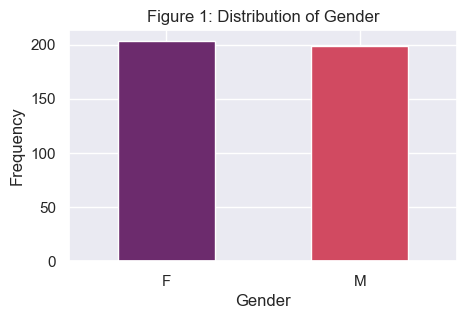

In [19]:
plt.figure(figsize=(5,3))
gender_counts.plot(kind='bar', title='Figure 1: Distribution of Gender', xlabel='Gender', ylabel='Frequency',
                   rot=0, color=[palette[-1], palette[-4]])
plt.show()

#### Alcoholism

In [20]:
# Distribution of comorbidity index
alc_counts = df_clean['alcoholism'].value_counts()
alc_counts

alcoholism
0    357
1     41
Name: count, dtype: int64

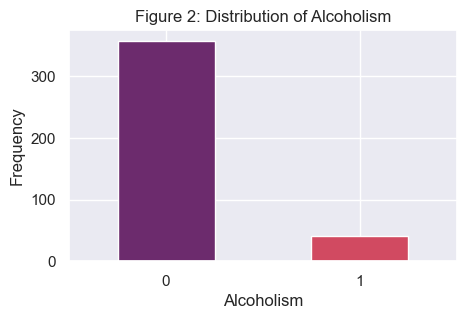

In [62]:
plt.figure(figsize=(5,3))
alc_counts.plot(kind='bar', title='Figure 2: Distribution of Alcoholism', xlabel='Alcoholism', ylabel='Frequency',
                   rot=0, color=[palette[-1], palette[-4]])
plt.show()

#### Anchor age

In [22]:
# Group age by 10 years
bins = list(range(20, 101, 10))
age_groups = pd.cut(df_clean['anchor_age'], bins=bins, right=False)
ageg_counts = age_groups.value_counts().sort_index()

# Grouped age counts
print(ageg_counts)

anchor_age
[20, 30)     27
[30, 40)     32
[40, 50)     52
[50, 60)     71
[60, 70)     93
[70, 80)     62
[80, 90)     47
[90, 100)    14
Name: count, dtype: int64


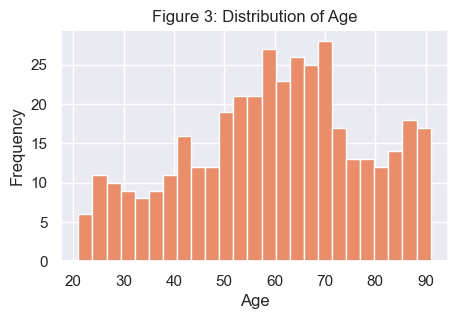

In [23]:
plt.figure(figsize=(5,3))
df_clean['anchor_age'].plot(kind='hist', title='Figure 3: Distribution of Age',ylabel='Frequency',
                      rot=0, bins=25).set_xlabel('Age')
plt.show()

#### Date of death

In [24]:
# Distribution of date of death
dod_counts = df['deathtime'].value_counts(dropna=False)
dod_counts[:10]

deathtime
NaN                    339
2164-09-06T02:23:00      1
2110-09-22T20:55:00      1
2180-07-23T05:44:00      1
2131-07-22T01:17:00      1
2149-07-25T15:00:00      1
2158-09-25T03:59:00      1
2161-09-17T15:43:00      1
2191-01-10T18:55:00      1
2178-03-03T16:00:00      1
Name: count, dtype: int64

In [25]:
print("Number of patients survived is", len(df[df.mortality == 'Survive']))
print(f"Mortality rate is {round(100* len(df[df.mortality == 'Dead']) / len(df),2)}%")

Number of patients survived is 339
Mortality rate is 15.67%


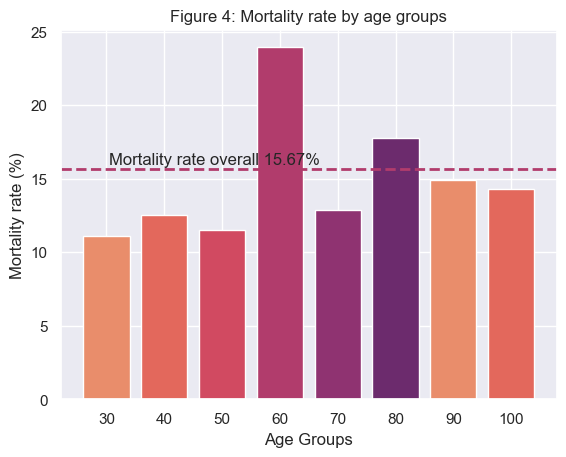

In [63]:
# Mortality rate in each age groups
rate_age = pd.DataFrame(zip(df['mortality'], age_groups), columns=['mortality', 'age_groups'])
total = rate_age.groupby(['age_groups']).count()
rate = pd.DataFrame(rate_age.groupby(['age_groups', 'mortality']).size()).reset_index().drop_duplicates(subset=['age_groups'], keep="first")
mortality_rate = 100 * rate.iloc[:,2].values / total.values[:,0]

plt.bar(["30", "40", "50", "60", "70", "80", "90", "100"], mortality_rate, color=palette)
plt.axhline(y=round(100* len(df[df.mortality == 'Dead']) / len(df),2), color=palette[3], linestyle='--', linewidth=2, label='Mortality rate')
plt.annotate('Mortality rate overall 15.67%', xy=(0, 20), xytext=(0.05, 16))

plt.xlabel("Age Groups")
plt.ylabel("Mortality rate (%)")
plt.title("Figure 4: Mortality rate by age groups")

plt.show()

Mortality rate drawn from dataset is approximately $15.67\%$. Older people have higher risk of mortality.

#### Others

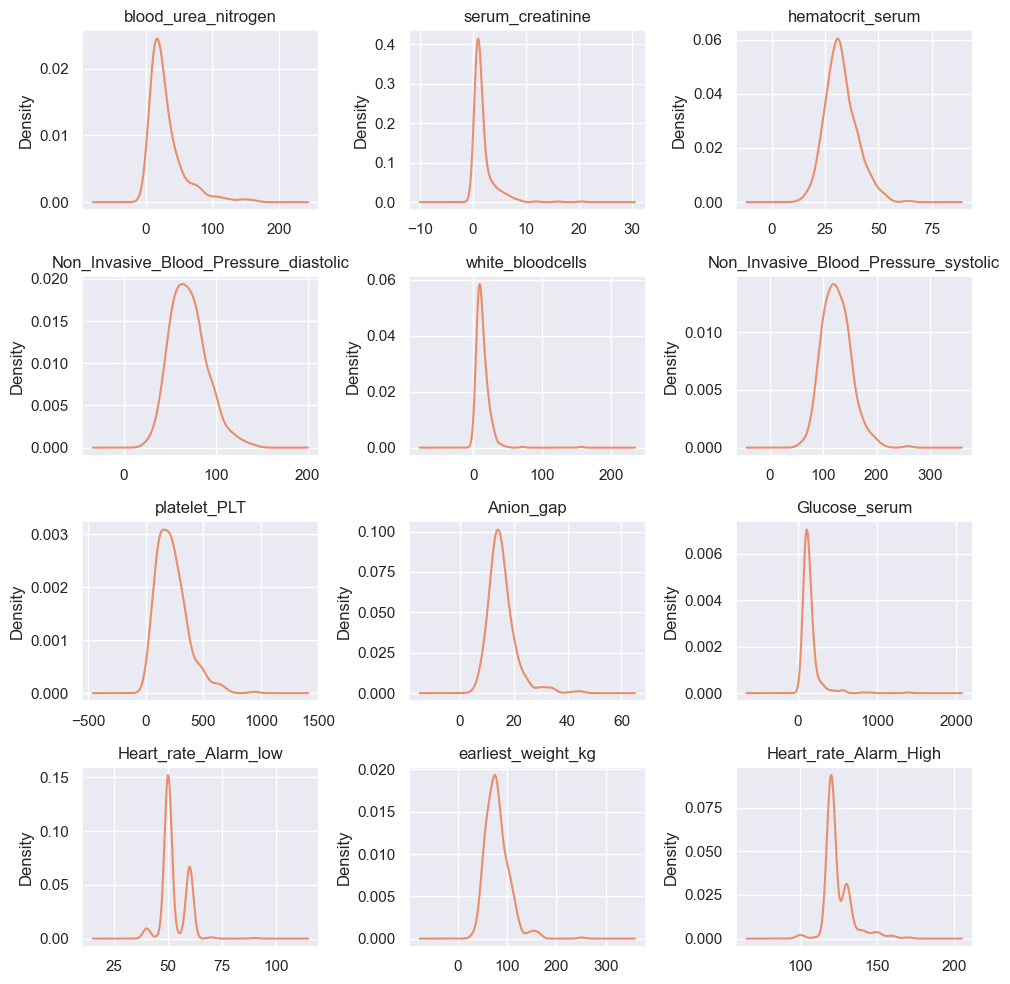

In [27]:
fig, axes = plt.subplots(4,3, figsize=(10,10))

for i, col in enumerate(features_kde):
    df_clean[col].plot(ax=axes[i//3, i%3-1], kind='kde', title=col)
    
plt.tight_layout()
plt.show()

## 3.3. Multivariate analysis

#### Helper function

In [28]:
"""
Plots histogram and boxplot to compare difference in distribution of given label
- label: the feature to be compared
- title: title of the figure
"""
def plot_mean_difference(df, label, title, colours):
    fig, axes = plt.subplots(2, len(features_kde), figsize=(30, 7))
    value = df[label].unique()
    p_vals = []

    for i in range(len(features_kde)):
        feature = features_kde[i]
        for j, val in enumerate(df[label].unique()):
            sns.kdeplot(df[df[label] == val][feature], ax=axes[0, i], fill=True, label=val, color=colours[j])
        axes[0, i].set(ylabel=None)
        axes[0, i].set(xlabel=None)
        axes[0, i].set_title(feature)

        sns.boxplot(ax=axes[1, i], x=label, y=feature, data=df, palette=colours)
        axes[1, i].set(ylabel=None)
        axes[1, i].set(xlabel=None)
        
        t_statistic, p_value = ttest_ind(df[df[label] == value[0]][feature].dropna(),
                                 df[df[label] == value[1]][feature].dropna())
        p_vals.append(p_value)
    axes[0,-1].legend(title=label)

    fig.suptitle(title)
    plt.show()
    return dict(zip(features_kde, p_vals))

"""
Plot coefficient correlation inside a pair plot, used in pair_plot function
"""
def reg_coef(x,y,label=None,color=None,hue=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    marker_size = abs(r) * 10000
    ax.scatter([.5], [.5], marker_size, [r], alpha=0.6, cmap="flare",
            vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

"""
Plot pair grid of bivariate analysis, includes scatter plot and correlation computation
- df: dataframe containing all features
- label: the feature to be compared
- title: title of figure
"""
def pair_plot(df, label, title, colours):
    g = sns.PairGrid(df, hue=label, diag_sharey=False, palette=colours)
    g.map_upper(reg_coef, hue=None)
    g.map_diag(sns.kdeplot, fill=True)
    g.map_lower(sns.scatterplot)

    g.add_legend(adjust_subtitles=True, title=label)
    g.fig.subplots_adjust(top=0.95)
    g.fig.suptitle(title)

    plt.show()

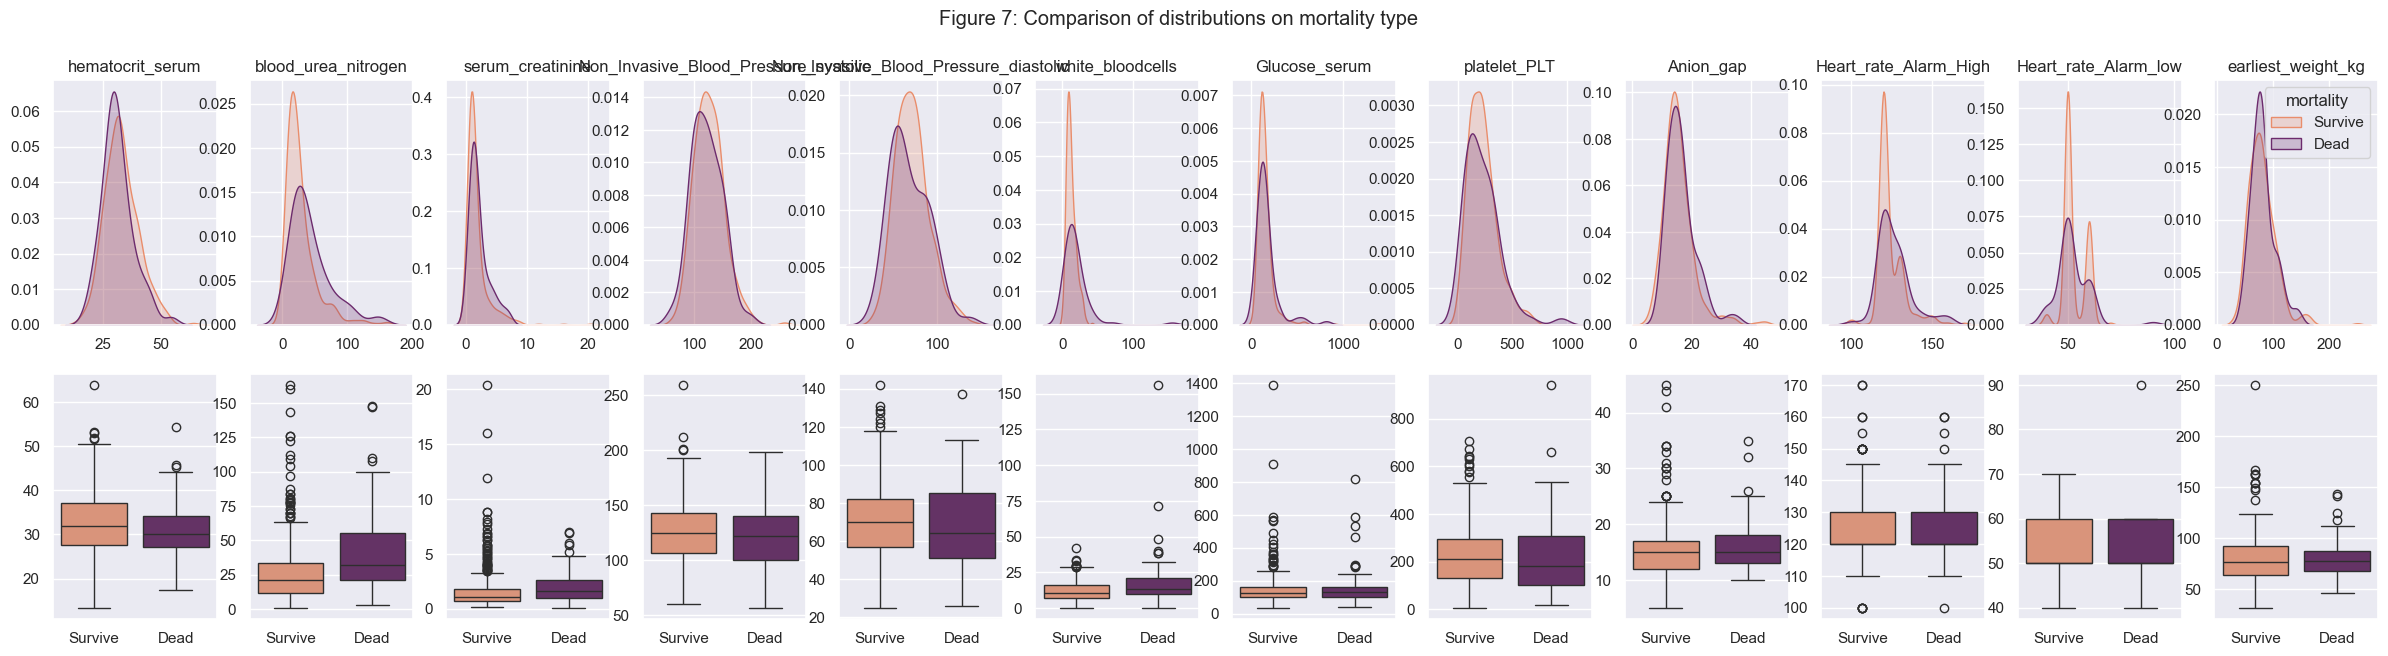

{'hematocrit_serum': 0.08676813089511148,
 'blood_urea_nitrogen': 4.612147389195352e-05,
 'serum_creatinine': 0.25975929393808206,
 'Non_Invasive_Blood_Pressure_systolic': 0.19825519699642882,
 'Non_Invasive_Blood_Pressure_diastolic': 0.2443231720853196,
 'white_bloodcells': 7.680635647023955e-06,
 'Glucose_serum': 0.34856162106085486,
 'platelet_PLT': 0.8745058416697706,
 'Anion_gap': 0.2319100392686956,
 'Heart_rate_Alarm_High': 0.08059738059712912,
 'Heart_rate_Alarm_low': 0.339233449366519,
 'earliest_weight_kg': 0.7810820088590978}

In [29]:
plot_mean_difference(df_clean, 'mortality', "Figure 7: Comparison of distributions on mortality type", [palette[0], palette[-1]])

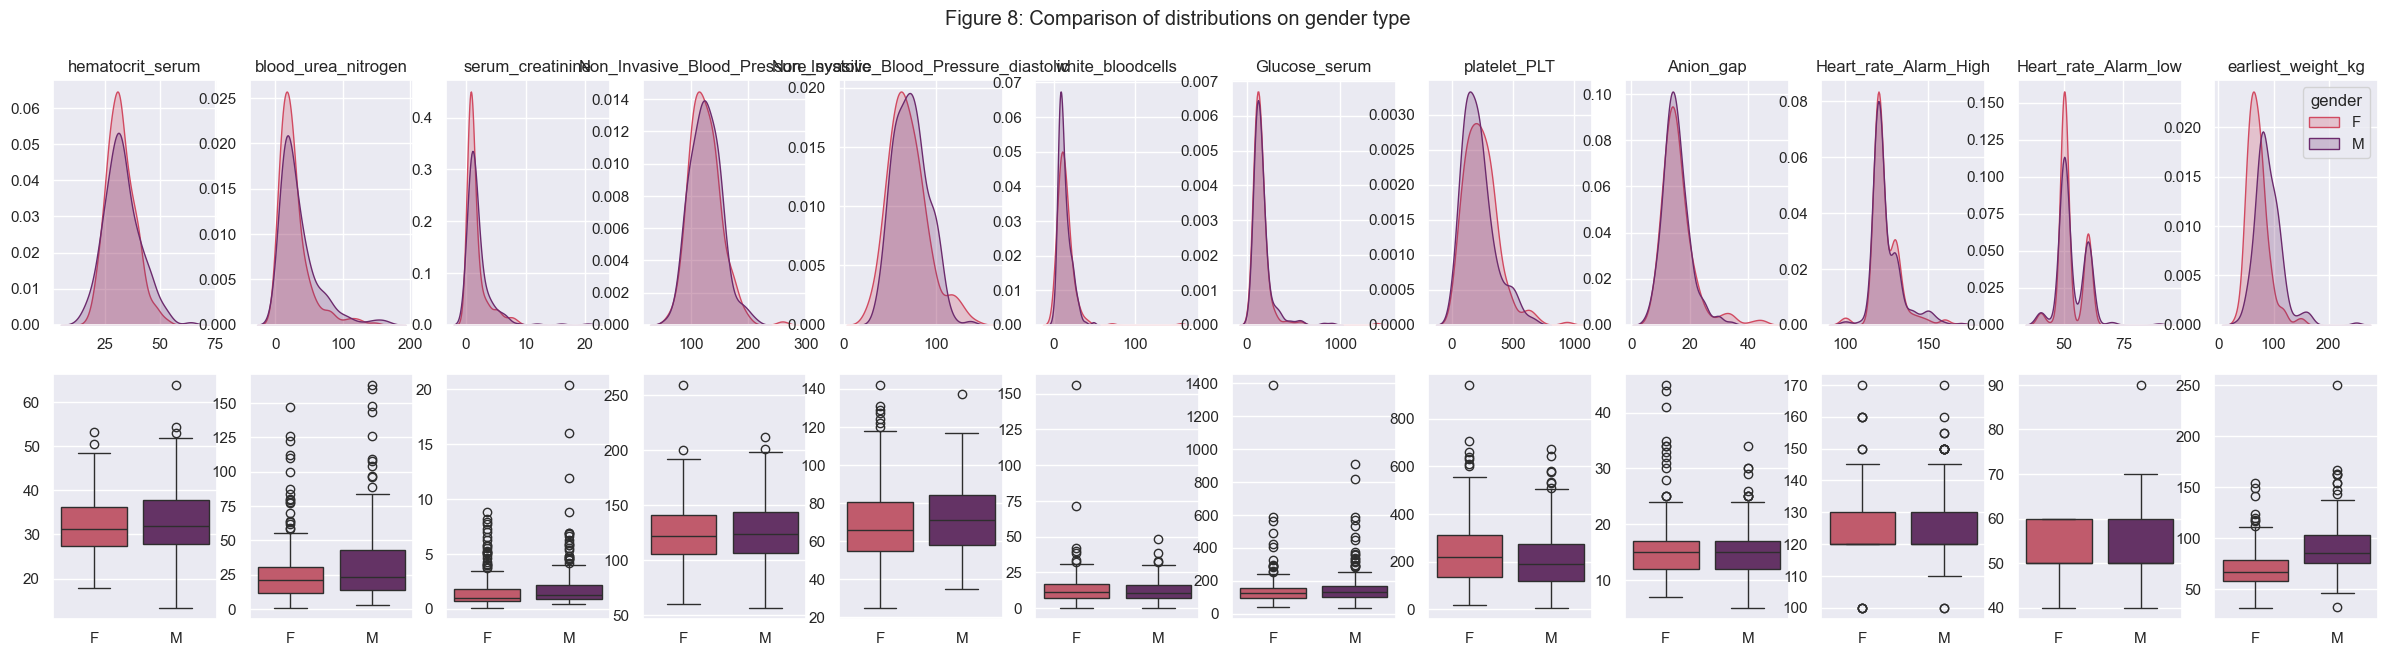

{'hematocrit_serum': 0.3240644694817958,
 'blood_urea_nitrogen': 0.007670229726352528,
 'serum_creatinine': 0.05158772393378235,
 'Non_Invasive_Blood_Pressure_systolic': 0.7296708041529067,
 'Non_Invasive_Blood_Pressure_diastolic': 0.10509871819338322,
 'white_bloodcells': 0.26067526395566293,
 'Glucose_serum': 0.35097802053808014,
 'platelet_PLT': 0.05542897940473232,
 'Anion_gap': 0.1578859977496517,
 'Heart_rate_Alarm_High': 0.5942017027176898,
 'Heart_rate_Alarm_low': 0.19751197992347372,
 'earliest_weight_kg': 2.272931347868152e-17}

In [30]:
plot_mean_difference(df_clean, 'gender', "Figure 8: Comparison of distributions on gender type", [palette[-4], palette[-1]])

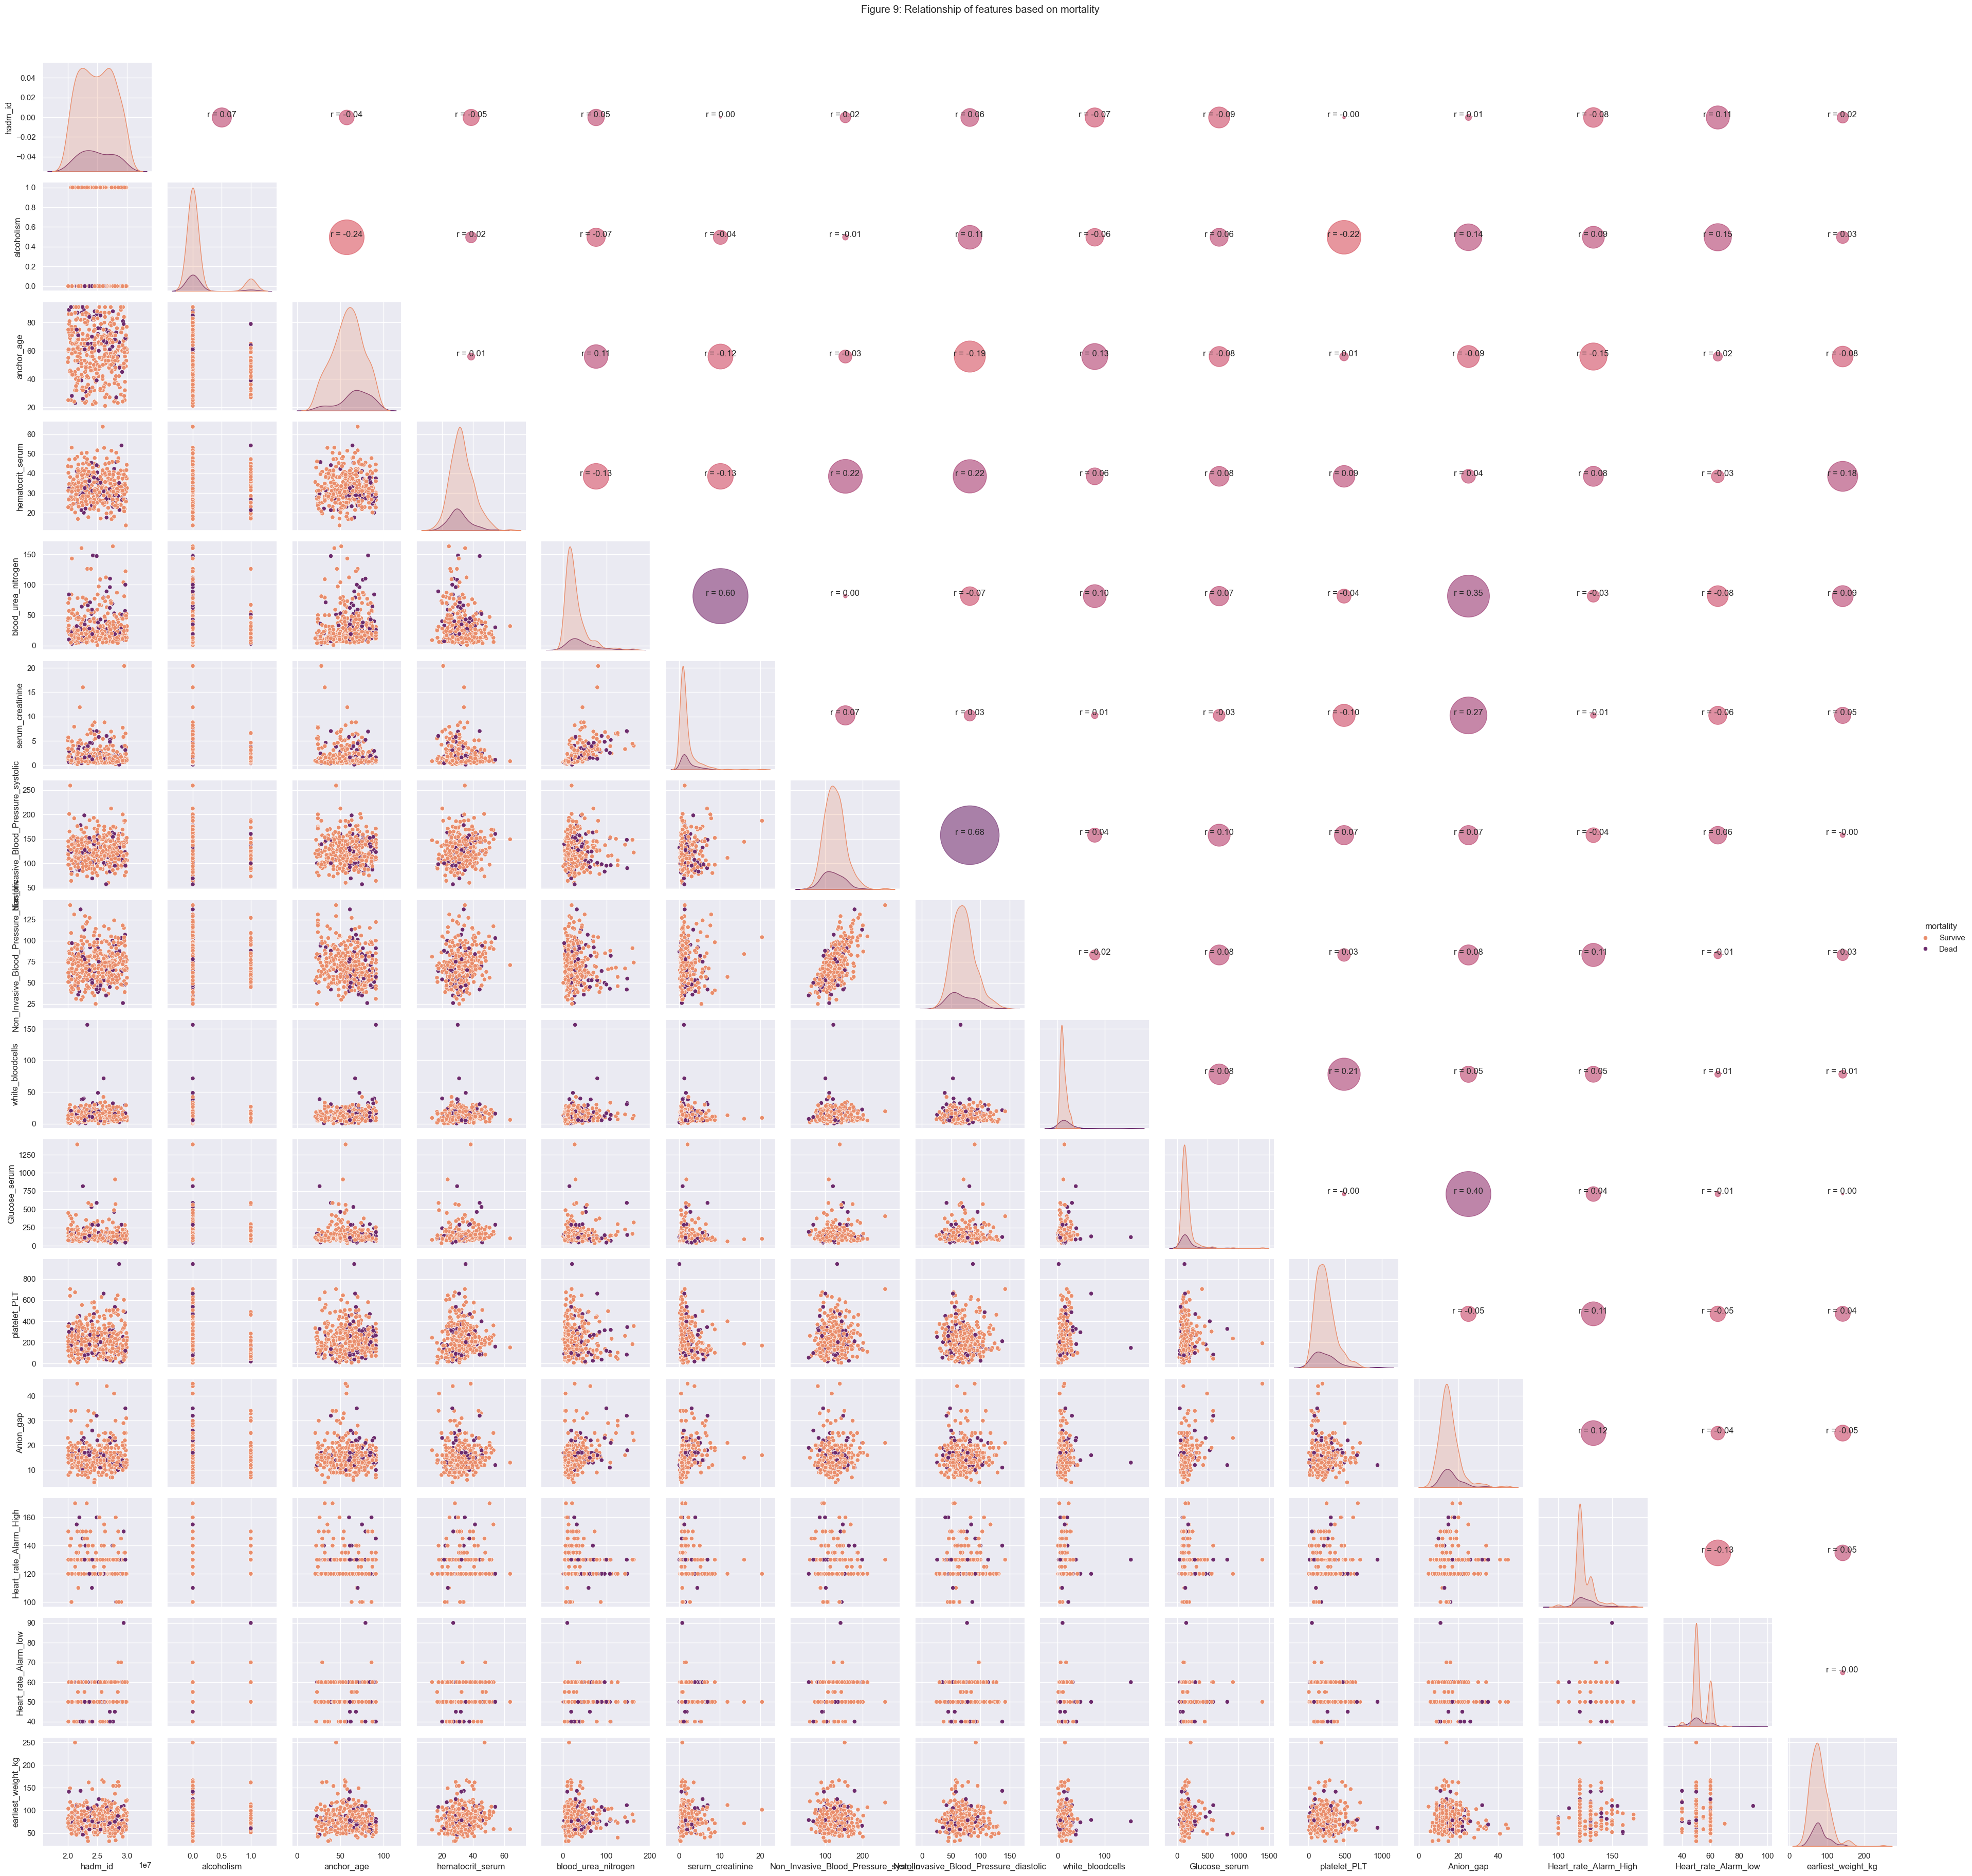

In [31]:
pair_plot(df_clean, 'mortality', "Figure 9: Relationship of features based on mortality", [palette[0], palette[-1]])

# 4. Preprocessing

In [32]:
# Drop gender
X = df_clean.drop(['hadm_id', 'gender', 'mortality'], axis=1)
X.head()

alcoholism  anchor_age  hematocrit_serum  blood_urea_nitrogen  \
0           0          71              31.3                 28.0   
1           0          89              19.9                 40.0   
2           0          84              22.5                 26.0   
3           0          37              29.5                 31.0   
4           0          47              29.9                 97.0   

   serum_creatinine  Non_Invasive_Blood_Pressure_systolic  \
0               1.2                                 158.0   
1               1.0                                 107.0   
2               0.7                                 118.0   
3               2.0                                  76.0   
4               6.8                                 137.0   

   Non_Invasive_Blood_Pressure_diastolic  white_bloodcells  Glucose_serum  \
0                                   61.0               4.6          127.0   
1                                   54.0              39.7          240.0   
2                                   96.0               7.1          116.0   
3                                   48.0              18.6          106.0   
4                                   85.0               9.7          110.0   

   platelet_PLT  Anion_gap  Heart_rate_Alarm_High  Heart_rate_Alarm_low  \
0         107.0       11.0                  125.0                  60.0   
1         183.0       23.0                  130.0                  40.0   
2         160.0       14.0                  120.0                  50.0   
3         239.0       13.0                  150.0                  40.0   
4         137.0       24.0                  130.0                  50.0   

   earliest_weight_kg  
0                59.7  
1                56.0  
2                78.1  
3                52.2  
4               103.4

In [33]:
X['gender'] = LabelEncoder().fit_transform(df_clean['gender'])
X['mortality'] = LabelEncoder().fit_transform(df_clean['mortality'])
X.head()

alcoholism  anchor_age  hematocrit_serum  blood_urea_nitrogen  \
0           0          71              31.3                 28.0   
1           0          89              19.9                 40.0   
2           0          84              22.5                 26.0   
3           0          37              29.5                 31.0   
4           0          47              29.9                 97.0   

   serum_creatinine  Non_Invasive_Blood_Pressure_systolic  \
0               1.2                                 158.0   
1               1.0                                 107.0   
2               0.7                                 118.0   
3               2.0                                  76.0   
4               6.8                                 137.0   

   Non_Invasive_Blood_Pressure_diastolic  white_bloodcells  Glucose_serum  \
0                                   61.0               4.6          127.0   
1                                   54.0              39.7          240.0   
2                                   96.0               7.1          116.0   
3                                   48.0              18.6          106.0   
4                                   85.0               9.7          110.0   

   platelet_PLT  Anion_gap  Heart_rate_Alarm_High  Heart_rate_Alarm_low  \
0         107.0       11.0                  125.0                  60.0   
1         183.0       23.0                  130.0                  40.0   
2         160.0       14.0                  120.0                  50.0   
3         239.0       13.0                  150.0                  40.0   
4         137.0       24.0                  130.0                  50.0   

   earliest_weight_kg  gender  mortality  
0                59.7       0          1  
1                56.0       0          0  
2                78.1       0          1  
3                52.2       0          1  
4               103.4       1          1

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.33888927,  0.62938744, -0.16212542, ..., -0.83916867,
        -0.99498744,  0.43365851],
       [-0.33888927,  1.64422687, -1.72389921, ..., -0.99123972,
        -0.99498744, -2.30596191],
       [-0.33888927,  1.36232703, -1.36770519, ..., -0.08292344,
        -0.99498744,  0.43365851],
       ...,
       [-0.33888927,  1.30594706, -0.03882749, ..., -1.07344029,
        -0.99498744,  0.43365851],
       [-0.33888927, -0.5545919 , -1.06631024, ...,  0.04037742,
         1.00503782,  0.43365851],
       [-0.33888927, -0.385452  , -1.23070749, ..., -1.25839157,
         1.00503782,  0.43365851]])

One of the feature of standard scaling is that, we can detect outliers by filtering values `abs(x) > 3.5`. We choose number `3.5` as it does not discard huge amount of data while still being reasonable number for an outlier.

In [35]:
# Outliers detection for each features
X_cleaned = pd.DataFrame(X_scaled)
X_cleaned = X_scaled[(np.abs(X_scaled) < 3.5).all(axis=1)]
df_clean = df_clean[(np.abs(X_scaled) < 3.5).all(axis=1)]
print("Number of cleaned record is", len(X_cleaned))
X_cleaned

Number of cleaned record is 365


array([[-3.38889272e-01,  6.29387439e-01, -1.62125420e-01, ...,
        -8.39168670e-01, -9.94987437e-01,  4.33658508e-01],
       [-3.38889272e-01,  1.64422687e+00, -1.72389921e+00, ...,
        -9.91239723e-01, -9.94987437e-01, -2.30596191e+00],
       [-3.38889272e-01,  1.36232703e+00, -1.36770519e+00, ...,
        -8.29234381e-02, -9.94987437e-01,  4.33658508e-01],
       ...,
       [-3.38889272e-01,  6.55877525e-02,  2.27182117e-03, ...,
        -7.47033812e-02,  1.00503782e+00, -2.30596191e+00],
       [-3.38889272e-01,  1.30594706e+00, -3.88274890e-02, ...,
        -1.07344029e+00, -9.94987437e-01,  4.33658508e-01],
       [-3.38889272e-01, -5.54591903e-01, -1.06631024e+00, ...,
         4.03774150e-02,  1.00503782e+00,  4.33658508e-01]])

# 5. Clustering


## 5.1. Finding optimal cluster

Firstly, we try the clustering on non-cleaned dataset.

In [36]:
wcss = []
ss = []

# Run algorithm through different number of clusters
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_scaled)

    # Record within cluster sum of squares
    wcss.append(kmeans.inertia_)

    # Record silhouette score
    sil_score = silhouette_score(X_scaled, kmeans.labels_)
    ss.append(sil_score)

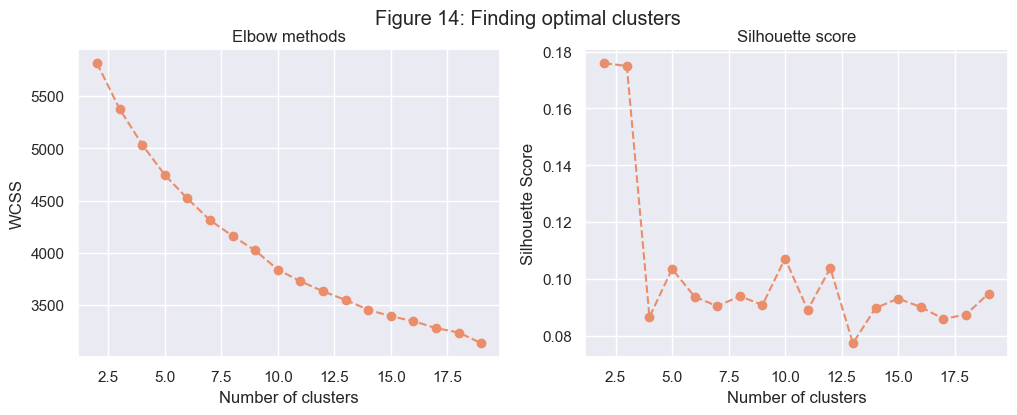

In [37]:
# Plot Elbow graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 20), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow methods')

# Plot Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range(2, 20), ss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score')

plt.suptitle("Figure 14: Finding optimal clusters")
plt.show()

From Figure 14, we can see that the cluster is not that visible. Further evaluation with silhouette score indicates that 2 and 3 cluster are the most optimal cluster as it gives the highest score.


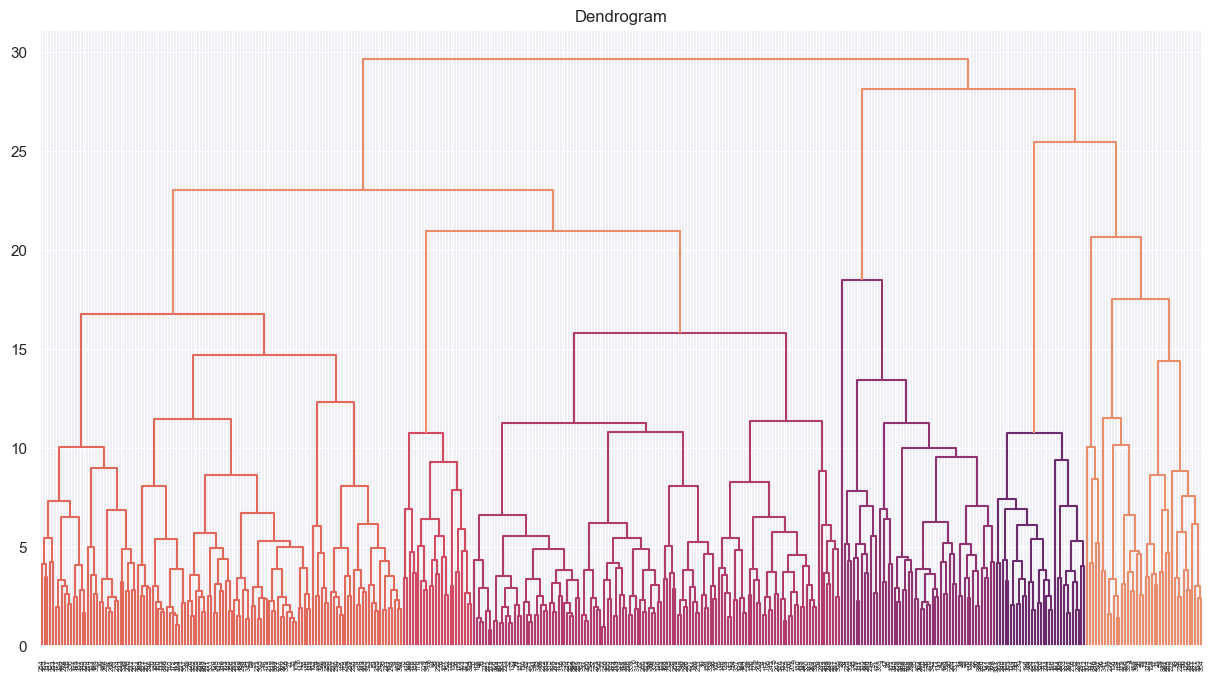

In [38]:
plt.figure(figsize=(15,8))

dendrogram = sch.dendrogram(sch.linkage(X_scaled, method  = "ward"))
plt.title('Dendrogram')
plt.show()

To further analyse the effect of outliers in the dataset, we perform clustering on cleaned dataset.

In [39]:
wcss = []
ss = []

# Run algorithm through different number of clusters
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_cleaned)

    # Record within cluster sum of squares
    wcss.append(kmeans.inertia_)

    # Record silhouette score
    sil_score = silhouette_score(X_cleaned, kmeans.labels_)
    ss.append(sil_score)

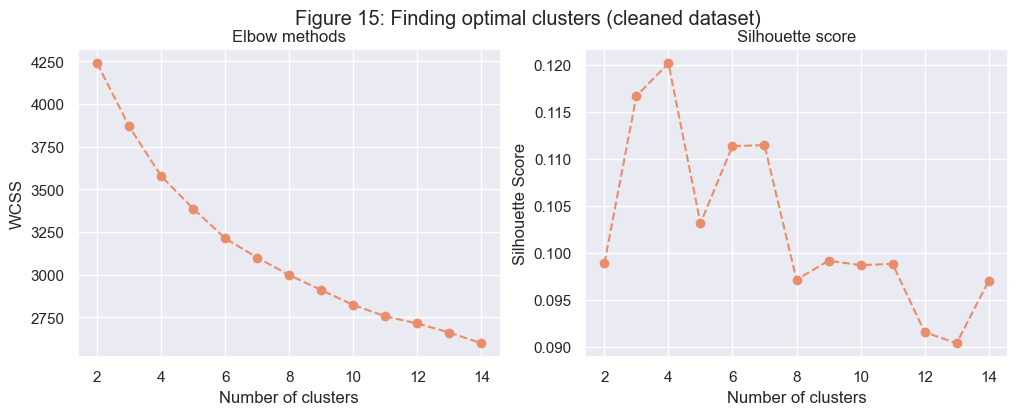

In [40]:
# Plot Elbow graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 15), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow methods')

# Plot Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), ss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score')

plt.suptitle("Figure 15: Finding optimal clusters (cleaned dataset)")
plt.show()

From Figure 15, we obtain that the best cluster to use on cleaned dataset is $4$. By removing high values (outliers) on the dataset contributes changes to the evaluation metrics and make the clusters more visible, achieving smaller WCSS and silhouette scores.

From this analysis, we can conclude that $3$ is the optimal cluster.

In [57]:
optimal_cluster = 4

## 5.2. Fitting the model

In [42]:
# Fit model
kmeans = KMeans(n_clusters=optimal_cluster, random_state=RANDOM_STATE)
kmeans.fit(X_cleaned)

df_clean['cluster'] = kmeans.labels_.astype(object)
df_clean.head()

hadm_id  alcoholism gender  anchor_age  hematocrit_serum  \
0  26100575           0      F          71              31.3   
1  22698313           0      F          89              19.9   
2  29562026           0      F          84              22.5   
3  21607777           0      F          37              29.5   
4  25233292           0      M          47              29.9   

   blood_urea_nitrogen  serum_creatinine  \
0                 28.0               1.2   
1                 40.0               1.0   
2                 26.0               0.7   
3                 31.0               2.0   
4                 97.0               6.8   

   Non_Invasive_Blood_Pressure_systolic  \
0                                 158.0   
1                                 107.0   
2                                 118.0   
3                                  76.0   
4                                 137.0   

   Non_Invasive_Blood_Pressure_diastolic  white_bloodcells  Glucose_serum  \
0                                   61.0               4.6          127.0   
1                                   54.0              39.7          240.0   
2                                   96.0               7.1          116.0   
3                                   48.0              18.6          106.0   
4                                   85.0               9.7          110.0   

   platelet_PLT  Anion_gap  Heart_rate_Alarm_High  Heart_rate_Alarm_low  \
0         107.0       11.0                  125.0                  60.0   
1         183.0       23.0                  130.0                  40.0   
2         160.0       14.0                  120.0                  50.0   
3         239.0       13.0                  150.0                  40.0   
4         137.0       24.0                  130.0                  50.0   

   earliest_weight_kg mortality cluster  
0                59.7   Survive       1  
1                56.0      Dead       0  
2                78.1   Survive       1  
3                52.2   Survive       1  
4               103.4   Survive       3

In [43]:
# Evaluation metric
wcss = kmeans.inertia_
ss = silhouette_score(X_cleaned, kmeans.labels_)

print(f"Fitting model with {optimal_cluster} clusters, resulting on {round(wcss,2)} WCSS and {round(ss,2)} silhouette score")

Fitting model with 4 clusters, resulting on 3578.21 WCSS and 0.12 silhouette score


In [44]:
# Center of clusters
kmeans_center = scaler.inverse_transform(kmeans.cluster_centers_)
pd.DataFrame(dict(zip(df_clean.columns, kmeans_center.T)))

hadm_id  alcoholism     gender  anchor_age  hematocrit_serum  \
0 -2.775558e-17   68.448980  30.697959   41.346939          2.051020   
1  0.000000e+00   60.849315  31.915753   22.897260          1.576712   
2  1.000000e+00   46.702703  33.905405   22.702703          1.472973   
3  4.163336e-17   60.646617  33.540602   30.233083          1.676692   

   blood_urea_nitrogen  serum_creatinine  \
0           121.877551         68.122449   
1           126.356164         69.630137   
2           123.540541         77.324324   
3           123.849624         70.706767   

   Non_Invasive_Blood_Pressure_systolic  \
0                             15.326531   
1                             12.379452   
2                             11.394595   
3                             12.036842   

   Non_Invasive_Blood_Pressure_diastolic  white_bloodcells  Glucose_serum  \
0                             150.306122        209.714286      16.020408   
1                             129.773973        239.116438      14.547945   
2                             148.729730        144.324324      16.837838   
3                             142.045113        226.172932      14.511278   

   platelet_PLT  Anion_gap  Heart_rate_Alarm_High  Heart_rate_Alarm_low  \
0    124.489796  51.428571              82.504082              0.591837   
1    122.465753  52.945205              66.878767              0.013699   
2    126.486486  53.783784              82.554054              0.594595   
3    123.984962  52.481203              92.284211              0.954887   

   earliest_weight_kg  
0            0.000000  
1            1.000000  
2            0.891892  
3            1.000000

## 5.3. Visualization

### Clusters Visualization

In [45]:
cluster_colors = [palette[0], palette[2], palette[-1], palette[-2]]

In [46]:
def stat_cum(cluster):
    cluster0 = df_clean[df_clean.cluster == cluster]
    print(f"Percentage of women and men (respectively) {round(100 * sum(cluster0.gender == 'F') / len(cluster0),2)} and {round(100 * sum(cluster0.gender == 'M') / len(cluster0),2)}")
    display(round(cluster0.describe(),2))

stat_cum(0)

Percentage of women and men (respectively) 40.82 and 59.18


hadm_id  alcoholism  anchor_age  hematocrit_serum  \
count        49.00        49.0       49.00             49.00   
mean   24766997.04         0.0       68.45             30.70   
std     2658408.72         0.0       16.56              6.39   
min    20189200.00         0.0       23.00             17.40   
25%    22698313.00         0.0       61.00             27.00   
50%    24540175.00         0.0       70.00             30.20   
75%    27110653.00         0.0       81.00             33.90   
max    29667230.00         0.0       91.00             45.80   

       blood_urea_nitrogen  serum_creatinine  \
count                49.00             49.00   
mean                 41.35              2.05   
std                  25.00              1.41   
min                  10.00              0.50   
25%                  22.00              1.10   
50%                  35.00              1.60   
75%                  53.00              2.40   
max                 110.00              6.00   

       Non_Invasive_Blood_Pressure_systolic  \
count                                 49.00   
mean                                 121.88   
std                                   28.20   
min                                   57.00   
25%                                  102.00   
50%                                  123.00   
75%                                  144.00   
max                                  198.00   

       Non_Invasive_Blood_Pressure_diastolic  white_bloodcells  Glucose_serum  \
count                                  49.00             49.00          49.00   
mean                                   68.12             15.33         150.31   
std                                    22.84              9.95          92.09   
min                                    26.00              0.30          45.00   
25%                                    51.00              9.60          94.00   
50%                                    64.00             12.80         133.00   
75%                                    84.00             20.30         168.00   
max                                   137.00             48.60         532.00   

       platelet_PLT  Anion_gap  Heart_rate_Alarm_High  Heart_rate_Alarm_low  \
count         49.00      49.00                  49.00                 49.00   
mean         209.71      16.02                 124.49                 51.43   
std          124.37       4.13                   8.97                  6.37   
min           25.00      10.00                 100.00                 40.00   
25%          103.00      13.00                 120.00                 50.00   
50%          199.00      15.00                 120.00                 50.00   
75%          299.00      18.00                 130.00                 60.00   
max          536.00      26.00                 155.00                 60.00   

       earliest_weight_kg  
count               49.00  
mean                82.50  
std                 20.41  
min                 53.40  
25%                 68.70  
50%                 78.30  
75%                 87.30  
max                143.30

In [47]:
# Statistical summary of cluster 1
stat_cum(1)

Percentage of women and men (respectively) 98.63 and 1.37


hadm_id  alcoholism  anchor_age  hematocrit_serum  \
count       146.00       146.0      146.00            146.00   
mean   24415641.21         0.0       60.85             31.92   
std     2881188.57         0.0       18.85              6.15   
min    20009550.00         0.0       21.00             13.40   
25%    21730234.50         0.0       49.00             27.45   
50%    24493533.00         0.0       62.00             31.25   
75%    26963627.25         0.0       75.00             35.68   
max    29804136.00         0.0       91.00             53.20   

       blood_urea_nitrogen  serum_creatinine  \
count               146.00            146.00   
mean                 22.90              1.58   
std                  18.59              1.74   
min                   1.00              0.20   
25%                  11.00              0.70   
50%                  18.00              0.90   
75%                  28.00              1.50   
max                 122.00              8.80   

       Non_Invasive_Blood_Pressure_systolic  \
count                                146.00   
mean                                 126.36   
std                                   25.27   
min                                   64.00   
25%                                  108.00   
50%                                  125.00   
75%                                  141.00   
max                                  200.00   

       Non_Invasive_Blood_Pressure_diastolic  white_bloodcells  Glucose_serum  \
count                                 146.00            146.00         146.00   
mean                                   69.63             12.38         129.77   
std                                    20.95              7.27          52.24   
min                                    25.00              0.20          58.00   
25%                                    55.25              7.12          93.50   
50%                                    66.50             10.80         121.00   
75%                                    80.00             15.80         147.00   
max                                   131.00             42.20         424.00   

       platelet_PLT  Anion_gap  Heart_rate_Alarm_High  Heart_rate_Alarm_low  \
count        146.00     146.00                 146.00                146.00   
mean         239.12      14.55                 122.47                 52.95   
std          121.60       3.85                   7.10                  5.14   
min           29.00       7.00                 100.00                 40.00   
25%          143.00      12.00                 120.00                 50.00   
50%          227.50      14.00                 120.00                 50.00   
75%          310.75      16.75                 120.00                 60.00   
max          640.00      30.00                 150.00                 60.00   

       earliest_weight_kg  
count              146.00  
mean                66.88  
std                 15.21  
min                 32.00  
25%                 55.25  
50%                 65.10  
75%                 76.22  
max                110.50

In [48]:
# Statistical summary of cluster 2
stat_cum(2)

Percentage of women and men (respectively) 40.54 and 59.46


hadm_id  alcoholism  anchor_age  hematocrit_serum  \
count        37.00        37.0       37.00             37.00   
mean   25422975.59         1.0       46.70             33.91   
std     3047864.20         0.0       11.35              8.29   
min    20561449.00         1.0       27.00             16.90   
25%    22400993.00         1.0       39.00             28.00   
50%    25550575.00         1.0       47.00             32.60   
75%    28026427.00         1.0       54.00             40.00   
max    29871774.00         1.0       65.00             54.30   

       blood_urea_nitrogen  serum_creatinine  \
count                37.00             37.00   
mean                 22.70              1.47   
std                  15.74              1.16   
min                   3.00              0.40   
25%                   9.00              0.70   
50%                  20.00              1.00   
75%                  32.00              1.70   
max                  67.00              4.60   

       Non_Invasive_Blood_Pressure_systolic  \
count                                 37.00   
mean                                 123.54   
std                                   26.30   
min                                   73.00   
25%                                  107.00   
50%                                  121.00   
75%                                  143.00   
max                                  188.00   

       Non_Invasive_Blood_Pressure_diastolic  white_bloodcells  Glucose_serum  \
count                                  37.00             37.00          37.00   
mean                                   77.32             11.39         148.73   
std                                    19.04              5.17          60.77   
min                                    45.00              2.90          66.00   
25%                                    64.00              7.80         105.00   
50%                                    76.00             11.30         139.00   
75%                                    88.00             15.00         184.00   
max                                   127.00             26.70         288.00   

       platelet_PLT  Anion_gap  Heart_rate_Alarm_High  Heart_rate_Alarm_low  \
count         37.00      37.00                  37.00                 37.00   
mean         144.32      16.84                 126.49                 53.78   
std           99.09       6.74                   8.73                  5.45   
min           18.00       7.00                 120.00                 50.00   
25%           84.00      13.00                 120.00                 50.00   
50%          129.00      16.00                 120.00                 50.00   
75%          163.00      18.00                 130.00                 60.00   
max          487.00      34.00                 150.00                 70.00   

       earliest_weight_kg  
count               37.00  
mean                82.55  
std                 21.82  
min                 51.90  
25%                 65.00  
50%                 77.20  
75%                 94.40  
max                161.90

In [49]:
# Statistical summary of cluster 2
stat_cum(3)

Percentage of women and men (respectively) 4.51 and 95.49


hadm_id  alcoholism  anchor_age  hematocrit_serum  \
count       133.00       133.0      133.00            133.00   
mean   25337886.14         0.0       60.65             33.54   
std     2700866.77         0.0       16.36              7.83   
min    20084622.00         0.0       22.00             16.60   
25%    23096626.00         0.0       50.00             28.30   
50%    25233292.00         0.0       61.00             32.50   
75%    27500212.00         0.0       72.00             39.30   
max    29995505.00         0.0       91.00             53.10   

       blood_urea_nitrogen  serum_creatinine  \
count               133.00            133.00   
mean                 30.23              1.68   
std                  22.71              1.45   
min                   4.00              0.40   
25%                  14.00              0.90   
50%                  22.00              1.20   
75%                  41.00              1.80   
max                 112.00              8.80   

       Non_Invasive_Blood_Pressure_systolic  \
count                                133.00   
mean                                 123.85   
std                                   26.71   
min                                   60.00   
25%                                  105.00   
50%                                  122.00   
75%                                  141.00   
max                                  212.00   

       Non_Invasive_Blood_Pressure_diastolic  white_bloodcells  Glucose_serum  \
count                                 133.00            133.00         133.00   
mean                                   70.71             12.04         142.05   
std                                    17.06              6.91          65.11   
min                                    37.00              0.40          36.00   
25%                                    57.00              7.20         103.00   
50%                                    70.00              9.90         125.00   
75%                                    82.00             16.10         165.00   
max                                   117.00             33.10         450.00   

       platelet_PLT  Anion_gap  Heart_rate_Alarm_High  Heart_rate_Alarm_low  \
count        133.00     133.00                 133.00                133.00   
mean         226.17      14.51                 123.98                 52.48   
std          129.97       3.88                   8.21                  5.35   
min            6.00       5.00                 100.00                 40.00   
25%          134.00      12.00                 120.00                 50.00   
50%          206.00      14.00                 120.00                 50.00   
75%          288.00      16.00                 130.00                 60.00   
max          645.00      29.00                 155.00                 70.00   

       earliest_weight_kg  
count              133.00  
mean                92.28  
std                 22.86  
min                 50.60  
25%                 77.20  
50%                 88.40  
75%                104.20  
max                163.00

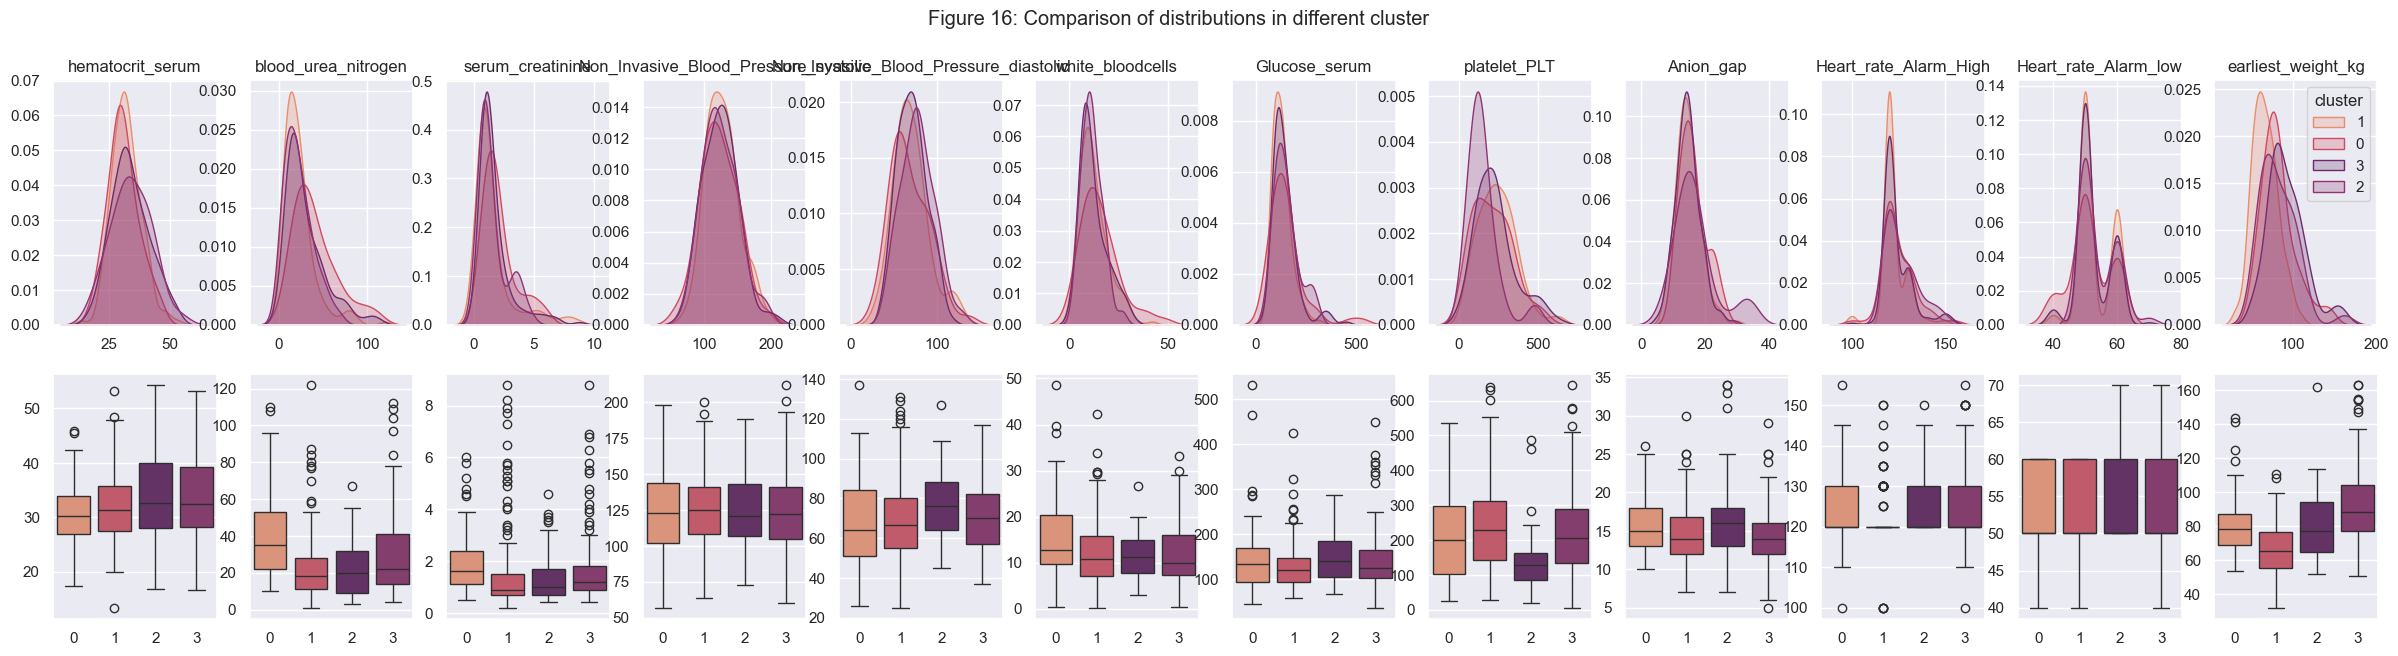

{'hematocrit_serum': 0.2362126456484199,
 'blood_urea_nitrogen': 1.2805526309130985e-07,
 'serum_creatinine': 0.08589020771044925,
 'Non_Invasive_Blood_Pressure_systolic': 0.2985789181599851,
 'Non_Invasive_Blood_Pressure_diastolic': 0.6705356171198387,
 'white_bloodcells': 0.027231117486403545,
 'Glucose_serum': 0.05528910540796193,
 'platelet_PLT': 0.14696780419879577,
 'Anion_gap': 0.023980850604597394,
 'Heart_rate_Alarm_High': 0.10877799138040994,
 'Heart_rate_Alarm_low': 0.09494526642526895,
 'earliest_weight_kg': 4.869969866400655e-08}

In [50]:
plot_mean_difference(df_clean, 'cluster', "Figure 16: Comparison of distributions in different cluster", colours=cluster_colors)

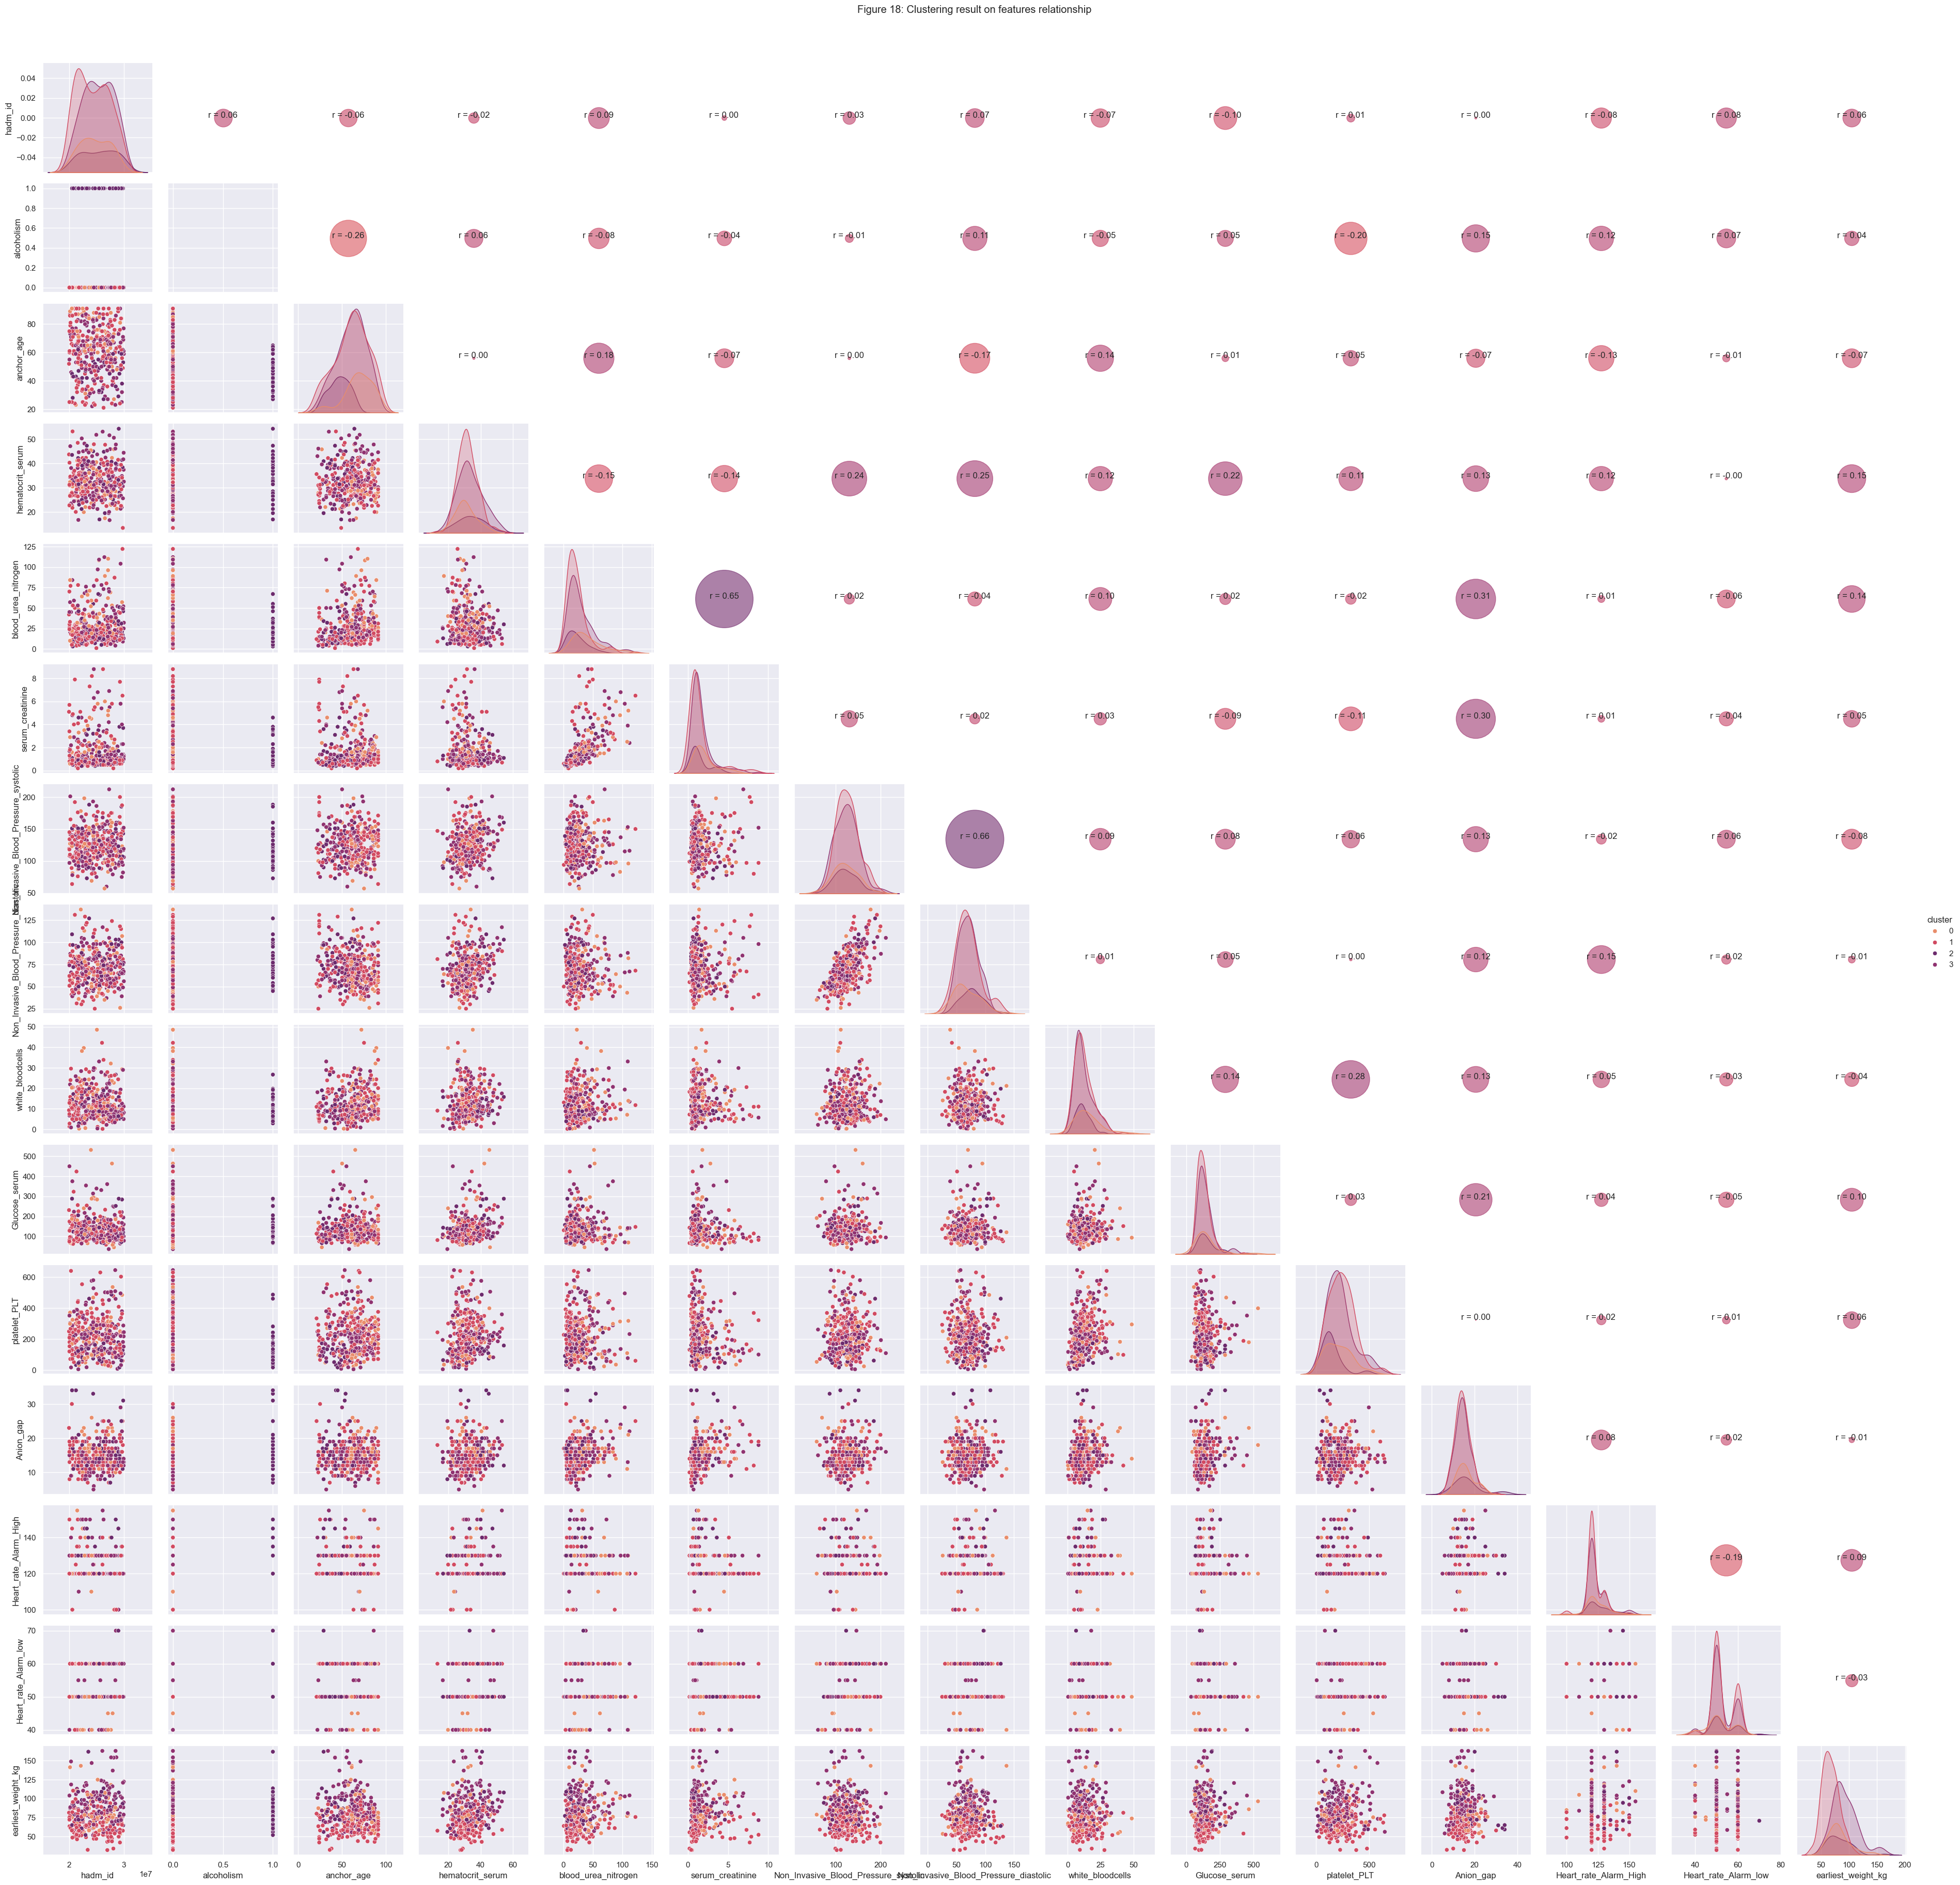

In [51]:
pair_plot(df_clean,'cluster', "Figure 18: Clustering result on features relationship", colours=cluster_colors)

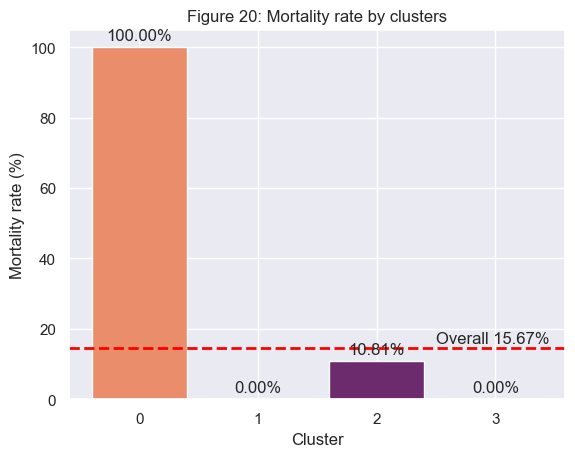

In [52]:
# Mortality rate in each cluster
mortality_cluster = []

for c in sorted(df_clean['cluster'].unique()):
    sub = df_clean[df_clean.cluster == c]
    mortality_cluster.append(100 * len(sub[sub.mortality == 'Dead']) / len(sub))

plt.bar(["0","1","2", "3"], mortality_cluster, color=cluster_colors)
plt.axhline(y=round(100* len(df_clean[df_clean.mortality == 'Dead']) / len(df_clean),2), color='red', linestyle='--', linewidth=2, label='Mortality rate')
plt.annotate('Overall 15.67%', xy=(0, 20), xytext=(2.5, 16))

for i, rate in enumerate(mortality_cluster):
    plt.text(i, rate + 1, f'{rate:.2f}%', ha='center', va='bottom')

plt.xlabel("Cluster")
plt.ylabel("Mortality rate (%)")
plt.title("Figure 20: Mortality rate by clusters")

plt.show()

### On PCA

In [53]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame for visualization
X_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
X_pca['cluster'] = df_clean['cluster']
X_pca

PC1       PC2       PC3 cluster
0   -0.985162 -0.555156  0.002268       1
1   -0.252781  3.053829  2.611894       0
2   -0.954371 -0.071840  0.307308       1
3   -1.078109  1.087547  0.223591       1
4    3.293839  1.781218 -1.018274       3
..        ...       ...       ...     ...
393  2.152677  1.382865 -0.149749       3
394  0.594634  0.616250 -0.308701       1
395 -1.858483  0.319266  1.556645       1
396  0.706402  1.995915 -0.794110       2
397  2.034669  0.617346 -0.012921       3

[398 rows x 4 columns]

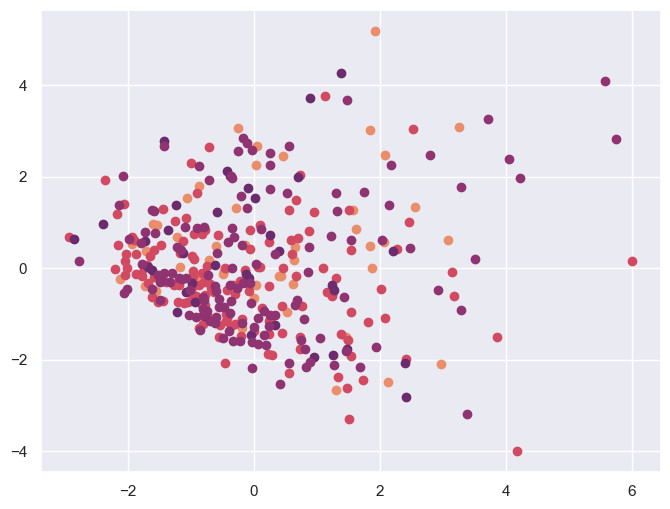

In [54]:
plt.figure(figsize=(8, 6))
for cluster in range(4):
    cluster_data = X_pca[X_pca['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'cluster {cluster}', color=cluster_colors[cluster])

In [56]:
import plotly.express as px

fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='cluster', title="Figure 12: Age, Comorbidity Index, and APS-III", color_discrete_sequence=cluster_colors)
fig.show()

# 6. Discussion

## 6.1. Property of the clusters

## 6.2. Relation to Outcomes